In [ ]:
#@title 1. Setup
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

plt.rcParams['figure.figsize'] = (6, 6)

def imshow_rgb(img_bgr, title=None):
    """Show a BGR image as RGB."""
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    if title is not None:
        plt.title(title)
    plt.axis("off")
    plt.show()

Saving IMG_4396.jpg to IMG_4396.jpg
Original image shape: (4032, 3024, 3)


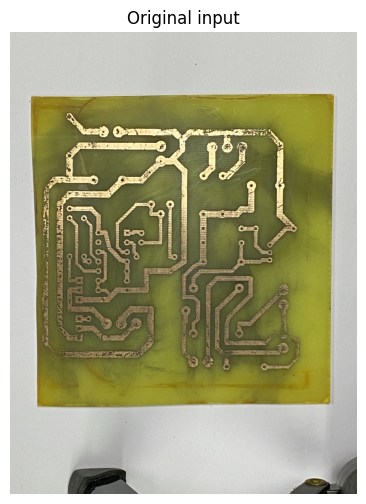

In [ ]:
#@title 2. Load PCB image
uploaded = files.upload()
img_path = list(uploaded.keys())[0]

full_bgr = cv2.imread(img_path)
if full_bgr is None:
    raise FileNotFoundError(img_path)

print("Original image shape:", full_bgr.shape)
imshow_rgb(full_bgr, "Original input")

After resize shape: (1024, 768, 3)
Cropped PCB shape: (711, 686, 3)


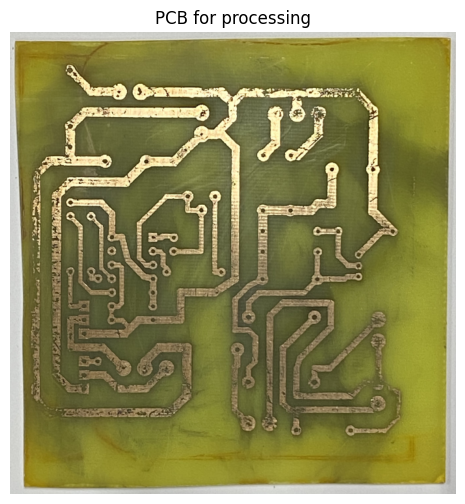

In [ ]:
#@title 3. Preprocess: resize + crop largest PCB board
max_side = 1024
H, W = full_bgr.shape[:2]
scale = min(max_side / max(H, W), 1.0)

if scale != 1.0:
    pcb_bgr = cv2.resize(full_bgr, (int(W * scale), int(H * scale)),
                         interpolation=cv2.INTER_AREA)
else:
    pcb_bgr = full_bgr.copy()

print("After resize shape:", pcb_bgr.shape)

hsv = cv2.cvtColor(pcb_bgr, cv2.COLOR_BGR2HSV)
Hc, Sc, Vc = cv2.split(hsv)

_, board_mask0 = cv2.threshold(Sc, 30, 255, cv2.THRESH_BINARY)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
board_mask = cv2.morphologyEx(board_mask0, cv2.MORPH_CLOSE, kernel, iterations=1)
board_mask = cv2.morphologyEx(board_mask, cv2.MORPH_OPEN,  kernel, iterations=1)

contours, _ = cv2.findContours(board_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

if len(contours) > 0:
    max_cnt = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(max_cnt)

    pad = int(0.01 * min(pcb_bgr.shape[0], pcb_bgr.shape[1]))
    x0 = max(x - pad, 0)
    y0 = max(y - pad, 0)
    x1 = min(x + w + pad, pcb_bgr.shape[1])
    y1 = min(y + h + pad, pcb_bgr.shape[0])

    pcb_bgr = pcb_bgr[y0:y1, x0:x1].copy()
    print("Cropped PCB shape:", pcb_bgr.shape)
else:
    print("Warning: could not find PCB board contour, using full image.")

imshow_rgb(pcb_bgr, "PCB for processing")

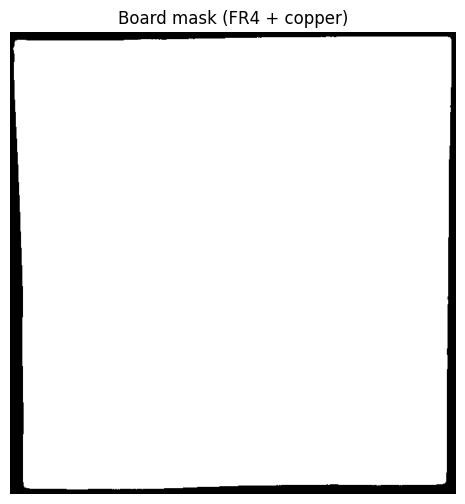

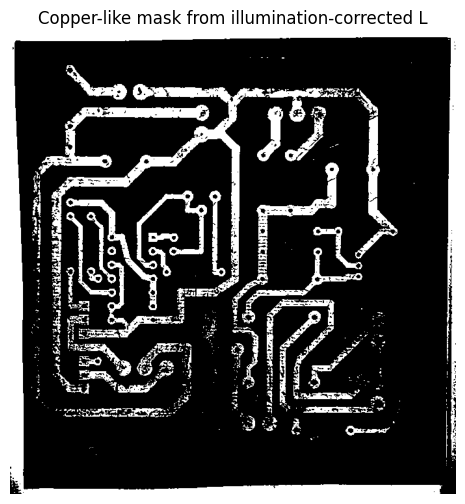

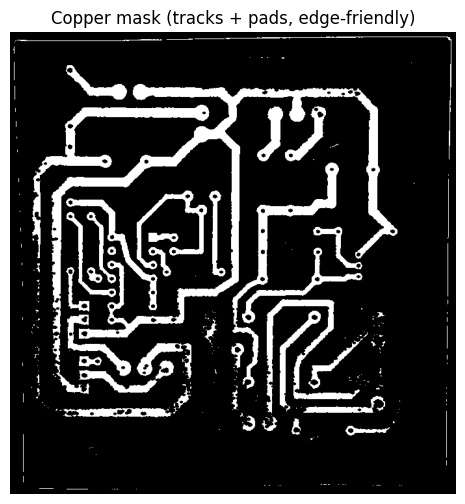

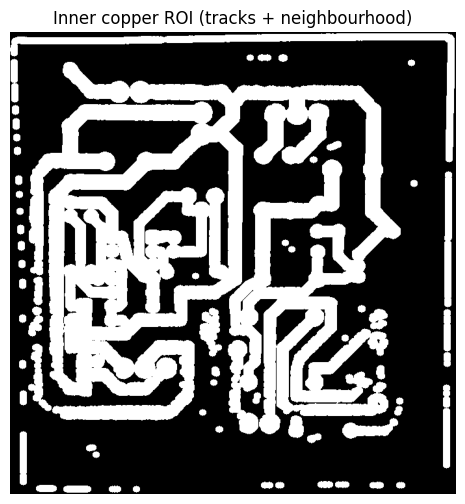

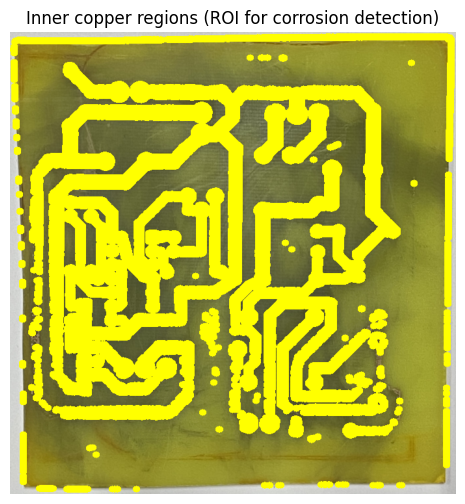

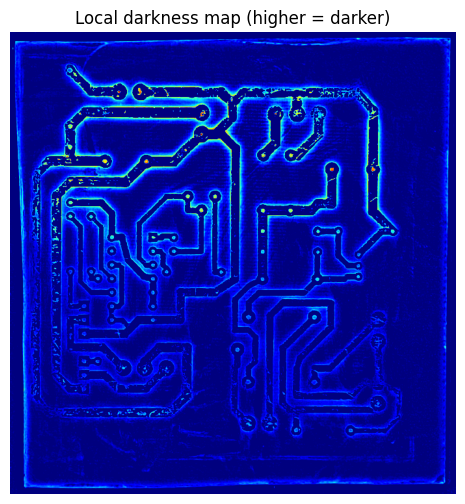

In [ ]:
#@title 4. Segment copper and get inner-copper mask 
gray = cv2.cvtColor(pcb_bgr, cv2.COLOR_BGR2GRAY)
H_img, W_img = gray.shape[:2]

hsv = cv2.cvtColor(pcb_bgr, cv2.COLOR_BGR2HSV)
H, S, V = cv2.split(hsv)
_, board_mask0 = cv2.threshold(S, 25, 255, cv2.THRESH_BINARY)

kernel_board = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
board_mask = cv2.morphologyEx(board_mask0, cv2.MORPH_CLOSE, kernel_board, iterations=1)
board_mask = cv2.morphologyEx(board_mask, cv2.MORPH_OPEN,  kernel_board, iterations=1)

plt.imshow(board_mask, cmap="gray")
plt.title("Board mask (FR4 + copper)")
plt.axis("off")
plt.show()

lab = cv2.cvtColor(pcb_bgr, cv2.COLOR_BGR2LAB)
L, A, B = cv2.split(lab)

L_f = L.astype(np.float32)
bg = cv2.GaussianBlur(L_f, (201, 201), 0)
ratio = cv2.divide(L_f, bg + 1)
ratio_n = cv2.normalize(ratio, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

ret_L, mask_L = cv2.threshold(ratio_n, 0, 255,
                              cv2.THRESH_BINARY + cv2.THRESH_OTSU)
if ratio_n[mask_L == 255].mean() < ratio_n[mask_L == 0].mean():
    mask_L = 255 - mask_L

plt.imshow(mask_L, cmap="gray")
plt.title("Copper-like mask from illumination-corrected L")
plt.axis("off")
plt.show()

mask_copper0 = cv2.bitwise_and(board_mask, mask_L)
kernel_copper = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
mask_copper = cv2.morphologyEx(mask_copper0, cv2.MORPH_CLOSE,
                               kernel_copper, iterations=1)

plt.imshow(mask_copper, cmap="gray")
plt.title("Copper mask (tracks + pads, edge-friendly)")
plt.axis("off")
plt.show()

kernel_roi = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
inner_copper = cv2.dilate(mask_copper, kernel_roi, iterations=1)

plt.imshow(inner_copper, cmap="gray")
plt.title("Inner copper ROI (tracks + neighbourhood)")
plt.axis("off")
plt.show()

overlay_inner = pcb_bgr.copy()
overlay_inner[inner_copper == 255] = (0, 255, 255)  
imshow_rgb(overlay_inner, "Inner copper regions (ROI for corrosion detection)")

sigma = 7
ksize = int(6 * sigma + 1)
if ksize % 2 == 0:
    ksize += 1

blur = cv2.GaussianBlur(gray, (ksize, ksize), sigmaX=sigma)
dark = cv2.subtract(blur, gray)
dark_norm = cv2.normalize(dark, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

plt.imshow(dark_norm, cmap="jet")
plt.title("Local darkness map (higher = darker)")
plt.axis("off")
plt.show()

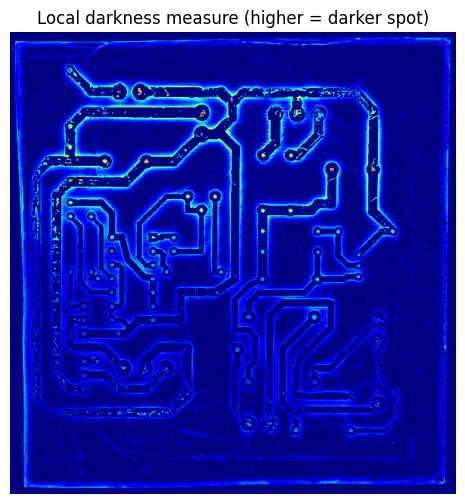

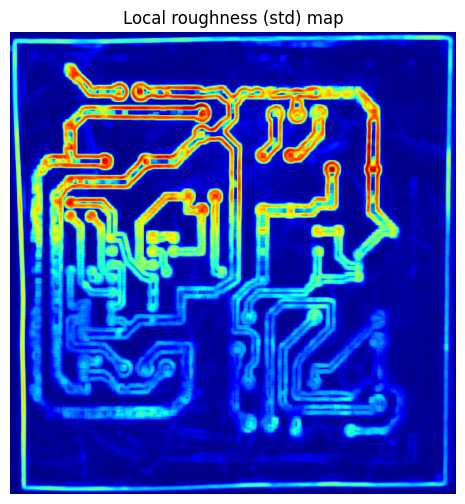

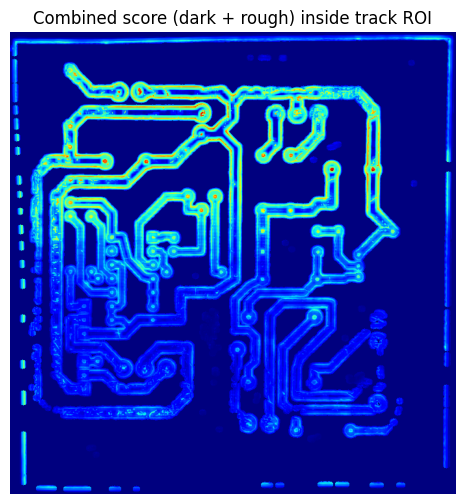

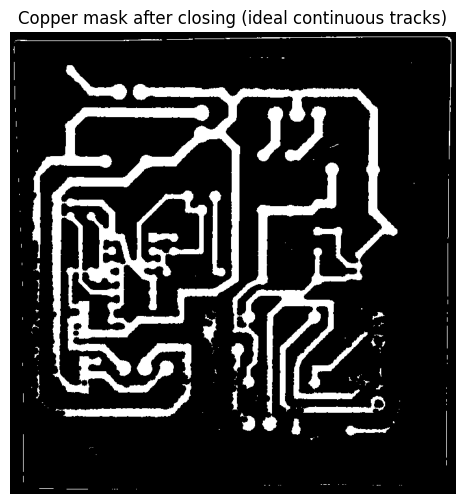

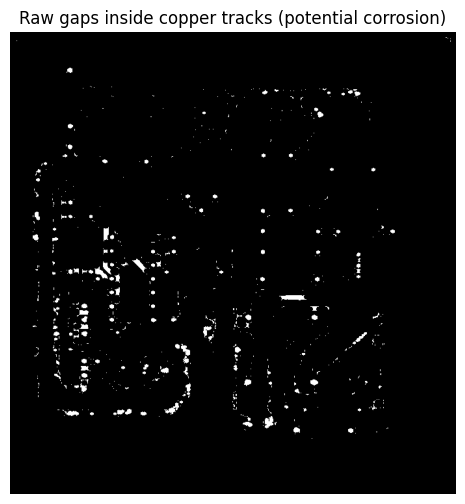

Bottom-half dark+rough threshold: 54.00


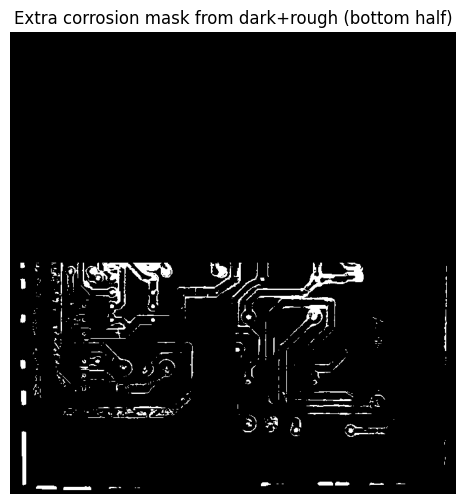

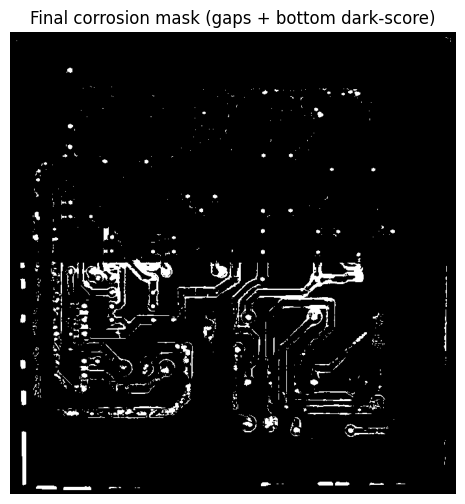

In [ ]:
#@title 5. Detect corrosion = copper gaps + dark/rough in bottom half (ver 2)
plt.imshow(dark_norm, cmap="jet")
plt.title("Local darkness measure (higher = darker spot)")
plt.axis("off")
plt.show()

gray_f = gray.astype(np.float32)
win = 9  #
mean = cv2.blur(gray_f, (win, win))
mean_sq = cv2.blur(gray_f * gray_f, (win, win))
var = mean_sq - mean * mean
var[var < 0] = 0
std_local = np.sqrt(var)

std_norm = cv2.normalize(std_local, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

plt.imshow(std_norm, cmap="jet")
plt.title("Local roughness (std) map")
plt.axis("off")
plt.show()

score = cv2.addWeighted(dark_norm, 0.5, std_norm, 0.5, 0)
score_inner = np.zeros_like(score, dtype=np.float32)
score_inner[inner_copper == 255] = score[inner_copper == 255]

plt.imshow(score_inner, cmap="jet")
plt.title("Combined score (dark + rough) inside track ROI")
plt.axis("off")
plt.show()

mask_copper_bin = (mask_copper > 0).astype(np.uint8) * 255
kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
copper_closed = cv2.morphologyEx(
    mask_copper_bin, cv2.MORPH_CLOSE, kernel_close, iterations=1
)

plt.imshow(copper_closed, cmap="gray")
plt.title("Copper mask after closing (ideal continuous tracks)")
plt.axis("off")
plt.show()

gap_raw = cv2.subtract(copper_closed, mask_copper_bin)
gap_raw = cv2.bitwise_and(gap_raw, inner_copper)  

plt.imshow(gap_raw, cmap="gray")
plt.title("Raw gaps inside copper tracks (potential corrosion)")
plt.axis("off")
plt.show()

h, w = score_inner.shape
mid = h // 2

mask_bottom = np.zeros_like(inner_copper, dtype=bool)
mask_bottom[mid:h, :] = True

vals_bottom = score_inner[(inner_copper == 255) & mask_bottom & (score_inner > 0)]

if len(vals_bottom) > 0:
    sensitivity_bottom = 0.15
    thr_bottom = np.percentile(vals_bottom, 100 * (1.0 - sensitivity_bottom))
    print(f"Bottom-half dark+rough threshold: {thr_bottom:.2f}")

    mask_dark_bottom = np.zeros_like(score_inner, dtype=np.uint8)
    cond_bottom = (
        (score_inner >= thr_bottom) &
        (inner_copper == 255) &
        mask_bottom
    )
    mask_dark_bottom[cond_bottom] = 255
else:
    print("No valid bottom-half pixels for dark+rough threshold.")
    mask_dark_bottom = np.zeros_like(score_inner, dtype=np.uint8)

plt.imshow(mask_dark_bottom, cmap="gray")
plt.title("Extra corrosion mask from dark+rough (bottom half)")
plt.axis("off")
plt.show()

mask_clean = cv2.bitwise_or(gap_raw, mask_dark_bottom.astype(np.uint8))

plt.imshow(mask_clean, cmap="gray")
plt.title("Final corrosion mask (gaps + bottom dark-score)")
plt.axis("off")
plt.show()

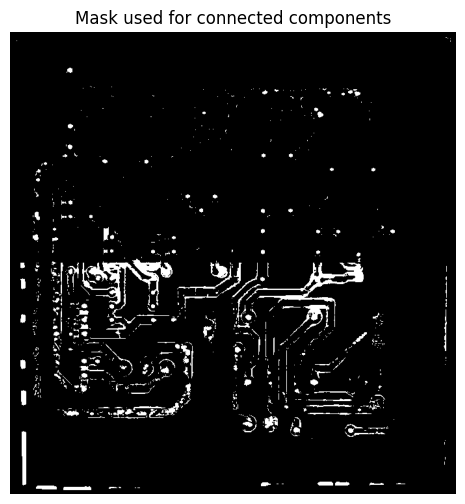

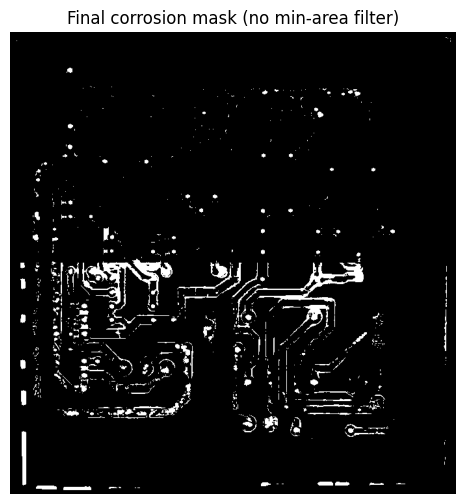

Number of suspected corrosion regions: 848


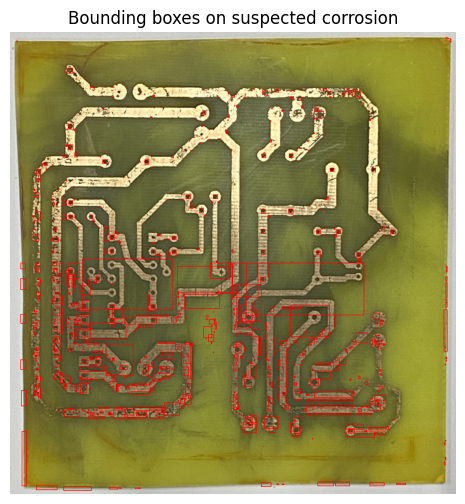

In [ ]:
#@title 6. CC visualization 
h, w = mask_clean.shape
border_margin = int(min(h, w) * 0.0)  
core = np.zeros_like(mask_clean)
core[border_margin:h-border_margin, border_margin:w-border_margin] = 255
mask_core = cv2.bitwise_and(mask_clean, core)

plt.imshow(mask_core, cmap="gray")
plt.title("Mask used for connected components")
plt.axis("off")
plt.show()

num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask_core)

components = []
mask_final = np.zeros_like(mask_core)

for label in range(1, num_labels):
    x, y, bw, bh, area = stats[label]
    components.append((x, y, bw, bh, area))
    mask_final[labels == label] = 255

plt.imshow(mask_final, cmap="gray")
plt.title("Final corrosion mask (no min-area filter)")
plt.axis("off")
plt.show()

print("Number of suspected corrosion regions:", len(components))

vis_bgr = pcb_bgr.copy()
for (x, y, bw, bh, area) in components:
    cv2.rectangle(vis_bgr, (x, y), (x + bw, y + bh), (0, 0, 255), 1)

imshow_rgb(vis_bgr, "Bounding boxes on suspected corrosion")